# Previsão de inadimplência de clientes de cartões de crédito

### Autor: Ángel Manuel Gálvez Límaco
A presente base foi obtida do conhecido site Kaggle e contém informação sobre o cumprimento dos pagamentos, fatores demográficos, histórico de pagamentos, extratos de contas e dados de créditos de clientes de cartões de crédito de clientes  em Taiwan em um período de seis meses: desde abril de 2005 até setembro de 2005.

### Objetivo: 
Prever a probabilidade de inadimplência dos clientes de cartões de crédito.

Importando as bibliotecas necessárias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice
import seaborn as sns
import imblearn
from tabulate import tabulate
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.metrics as metrics
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from fast_ml.feature_selection import get_constant_features

Importando o dataset:

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(r'C:\Users\Asus\Desktop\desafio\desafio_4int\UCI_Credit_Card.csv')

## Análise Exploratória (EDA)

In [3]:
print('O dataset apresenta', df.shape[0], 'linhas e', df.shape[1]-1, 'features')

O dataset apresenta 30000 linhas e 24 features


In [4]:
df.head(4)

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2     3913.0     3102.0      689.0        0.0        0.0   
1      0      2     2682.0     1725.0     2682.0     3272.0     3455.0   
2      0      0    29239.0    14027.0    13559.0    14331.0    14948.0   
3      0      0    46990.0    48233.0    49291.0    28314.0    28959.0   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0        0.0       0.0     689.0       0.0       0.0       0.0       0.0   
1     3261.0       0.0    1000.0    1000.0    1000.0       0.0    2000.0   
2    15549.0    1518.0    1500.0    1000.0    1000.0    1000.0    5000.0   
3    29547.0    2000.0    2019.0    1200.0    1100.0    1069.0    1000.0   

   default.payment.next.month  
0                           1  
1                           1  
2                           0  
3                           0

A variável alvo é 'default.payment.next.month', que é 1 se o cliente vai se tornar inadimplemente no pagamento correspondente ao próximo mês. 

In [5]:
df.ID.nunique()

30000

Observa-se que a variável 'ID' é um identificador único para cada linha, então é uma feature irrelevante para o modelo preditivo. Portanto, a feature 'ID' pode ser desconsiderada:

In [6]:
df.drop(columns = ['ID'], inplace = True)

In [7]:
df.shape

(30000, 24)

Agora, podemos obter a quantidade de linhas duplicadas:

In [8]:
df[df.duplicated() == True].shape

(35, 24)

Observa-se que existen 35 linhas duplicadas e estas podem ser desconsideradas porque não aportam informação nova ao modelo preditivo.

In [9]:
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace=True)

In [10]:
df.shape

(29965, 24)

Agora temos 29965 linhas únicas.

In [11]:
round(df[df.columns[23]].value_counts(normalize = True),4)

0    0.7787
1    0.2213
Name: default.payment.next.month, dtype: float64

Nosso dataset é altamente desbalanceado: apenas o 22.13% dos clientes apresentam inadimplência no pagamento. Este é um caso típico de detecção de anomalias, no qual tentamos prever uma variável que apresenta um alto risco de perda para a empresa.

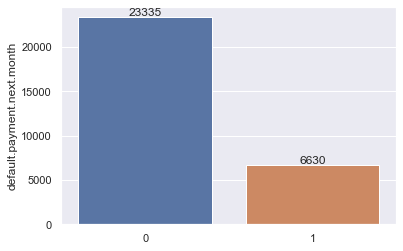

In [12]:
#Gráfico de barras
sns.set(rc={'figure.figsize':(6,4)})
sns.set(font_scale = 1)
ax = sns.barplot(y = df['default.payment.next.month'].value_counts(), x=[0,1], orient = 'v')
for i in ax.containers:
    ax.bar_label(i,);

Agora podemos observar se existem dados faltantes no dataset:

In [13]:
df.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

O dataset está completo e não existem dados faltantes. Portanto, não é necessário imputar as features que apresentam dados faltantes.

O seguinte passo é usar estatística descritiva para entender as features.

In [14]:
df.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    29965.000000  29965.000000  29965.000000  29965.000000  29965.000000   
mean    167442.005006      1.603738      1.853629      1.551877     35.487969   
std     129760.135222      0.489128      0.790411      0.521997      9.219459   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  29965.000000  29965.000000  29965.000000  29965.000000  29965.000000   
mean      -0.016753     -0.131854     -0.164392     -0.218922     -0.264509   
std        1.123492      1.196322      1.195878      1.168175      1.132220   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

              PAY_6      BILL_AMT1      BILL_AMT2     BILL_AMT3  \
count  29965.000000   29965.000000   29965.000000  2.996500e+04   
mean      -0.289438   51283.009778   49236.366294  4.706792e+04   
std        1.149090   73658.132403   71195.567392  6.937135e+04   
min       -2.000000 -165580.000000  -69777.000000 -1.572640e+05   
25%       -1.000000    3595.000000    3010.000000  2.711000e+03   
50%        0.000000   22438.000000   21295.000000  2.013500e+04   
75%        0.000000   67260.000000   64109.000000  6.020100e+04   
max        8.000000  964511.000000  983931.000000  1.664089e+06   

           BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count   29965.000000   29965.000000   29965.000000   29965.000000   
mean    43313.329885   40358.334390   38917.012281    5670.099316   
std     64353.514373   60817.130623   59574.147742   16571.849467   
min   -170000.000000  -81334.000000 -339603.000000       0.000000   
25%      2360.000000    1787.000000    1262.000000    1000.000000   
50%     19081.000000   18130.000000   17124.000000    2102.000000   
75%     54601.000000   50247.000000   49252.000000    5008.000000   
max    891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2       PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  2.996500e+04   29965.000000   29965.000000   29965.000000   
mean   5.927983e+03    5231.688837    4831.617454    4804.897047   
std    2.305346e+04   17616.361124   15674.464538   15286.372298   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    8.500000e+02     390.000000     300.000000     261.000000   
50%    2.010000e+03    1804.000000    1500.000000    1500.000000   
75%    5.000000e+03    4512.000000    4016.000000    4042.000000   
max    1.684259e+06  896040.000000  621000.000000  426529.000000   

            PAY_AMT6  default.payment.next.month  
count   29965.000000                29965.000000  
mean     5221.498014                    0.221258  
std     17786.976864                    0.415101  
min         0.000000                    0.000000  
25%       131.000000                    0.000000  
50%      1500.000000                    0.000000  
75%      4000.000000                    0.000000  
max    528666.000000                    1.000000

De acordo com a descrição do data set:
- 'SEX': 1 = masculino, 2 = feminino.
- 'EDUCATION': 1 = pós-graduação, 2 = graduação, 3 = ensino médio, 4 = outros, 5 = desconhecido, 6 = desconhecido.
- 'MARRIAGE': 1 = casado, 2 = solteiro, 3 = outros.
- De 'PAY_0' até 'PAY_6': Estado do pagamento. -1 = pago antes da data limite, 1 = pagamento atrasado 1 mês, 2 = pagamento atrasado 2 mêses, ..., 9 = pagamento atrasado 9 mêses.
- De 'BILL_AMT1' até 'BILL_AMT6': extrato da fatura no mês correspondente.
- De 'PAY_AMT1' até 'PAY_AMT6': quantidade do pagamento prévio no mês correspondente.

A feature 'PAY_0' deveria se chamar de 'PAY_1' para seguir a lógica dos outros nomes.

Por outro lado, apenas, aproximadamente, o 40% dos clientes são homens.

In [15]:
round(df.SEX.value_counts(normalize = True), 4)

2    0.6037
1    0.3963
Name: SEX, dtype: float64

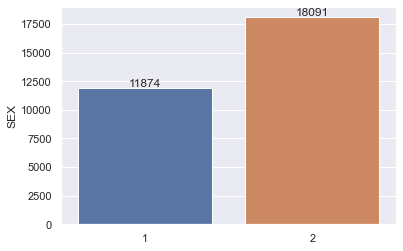

In [16]:
#Gráfico de barras
sns.set(rc={'figure.figsize':(6,4)})
sns.set(font_scale = 1)
ax = sns.barplot(y = df['SEX'].value_counts(), x=[2,1], orient = 'v')
for i in ax.containers:
    ax.bar_label(i,);

<AxesSubplot:xlabel='SEX', ylabel='count'>

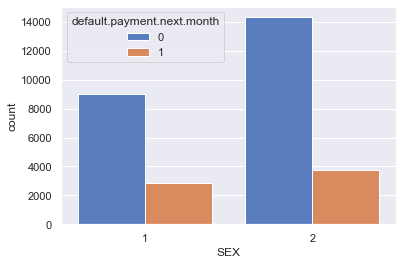

In [17]:
sns.countplot(x='SEX', data=df,hue='default.payment.next.month', palette="muted")

Do gráfico acima pode-se afirmar que existem mais mulheres inadimplentes do que homens inadimplentes. Similarmente, mais mulheres são não inadimplentes do que homens inadimplentes.

Os histogramas que podem fornecer informação útil são:

<AxesSubplot:xlabel='AGE', ylabel='Count'>

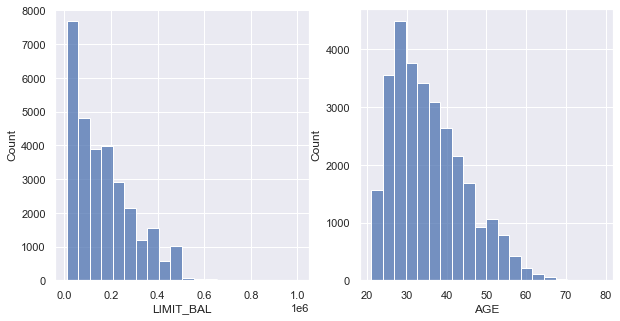

In [18]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set(font_scale = 1)
f, axes = plt.subplots(1, 2)
sns.histplot(data = df, x = 'LIMIT_BAL', color = 'b', bins = 20, ax = axes[0])
sns.histplot(data = df, x = 'AGE', color = 'b', bins = 20, ax = axes[1])

Levando em conta a feature 'AGE', é possível afirmar que as idades dos clientes estão entre 21 e 79 anos, sendo que a maioria de clientes têm entre 25 e 40 anos.

Observa-se que o crédito disponível dos clientes varia entre 10000 e 1000000 dólares tailandêses.

As features 'AGE' e 'LIMIT_BAL' apresentam uma distribuição assimétrica à direita.

Agora, vejamos os valores possíveis das features 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', ..., e 'PAY_6':

In [19]:
df.EDUCATION.value_counts()

2    14019
1    10563
3     4915
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

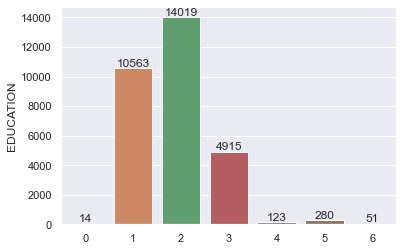

In [20]:
#Gráfico de barras
sns.set(rc={'figure.figsize':(6,4)})
sns.set(font_scale = 1)
ax = sns.barplot(y = df['EDUCATION'].value_counts(), x=[2,1,3,5,4,6,0], orient = 'v')
for i in ax.containers:
    ax.bar_label(i,);

In [21]:
df.MARRIAGE.value_counts()

2    15945
1    13643
3      323
0       54
Name: MARRIAGE, dtype: int64

In [22]:
df.PAY_0.value_counts()

 0    14737
-1     5682
 1     3667
-2     2750
 2     2666
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64

- A feature 'EDUCATION' tem 0 como um possível valor adicional, porém este valor não está indicado na descrição do dataset. Este valor poderia ser uma informação errada ou alguma categoria que não foi especificada. 
- A feature 'MARRIAGE' também tem 0 como um possível valor adicional. Será necessário imputar este valor.
- As features 'PAY_0', 'PAY_2', até 'PAY_6' têm 0 e -2 como categorias adicionais. Porém, estes valores não foram especificados.
  
Estas categorias desconhecidas deverão ser cuidadosamente processadas na modelagem. A forma mais simples seria desconsiderar as linhas com categorias desconhecidas, porém isto poderia influenciar negativamente no modelo preditivo porque as bases de treino e teste seriam menores.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   29965 non-null  float64
 1   SEX                         29965 non-null  int64  
 2   EDUCATION                   29965 non-null  int64  
 3   MARRIAGE                    29965 non-null  int64  
 4   AGE                         29965 non-null  int64  
 5   PAY_0                       29965 non-null  int64  
 6   PAY_2                       29965 non-null  int64  
 7   PAY_3                       29965 non-null  int64  
 8   PAY_4                       29965 non-null  int64  
 9   PAY_5                       29965 non-null  int64  
 10  PAY_6                       29965 non-null  int64  
 11  BILL_AMT1                   29965 non-null  float64
 12  BILL_AMT2                   29965 non-null  float64
 13  BILL_AMT3                   299

Nosso dataset apresenta as features categóricas: 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' e 'PAY_6', e as features numéricas: 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2, 'PAY_AMT3, 'PAY_AMT4, 'PAY_AMT5 e 'PAY_AMT6'.

Logo, vamos usar a análise bivariada para estudar a dependência entre as features:

<AxesSubplot:xlabel='SEX', ylabel='MARRIAGE'>

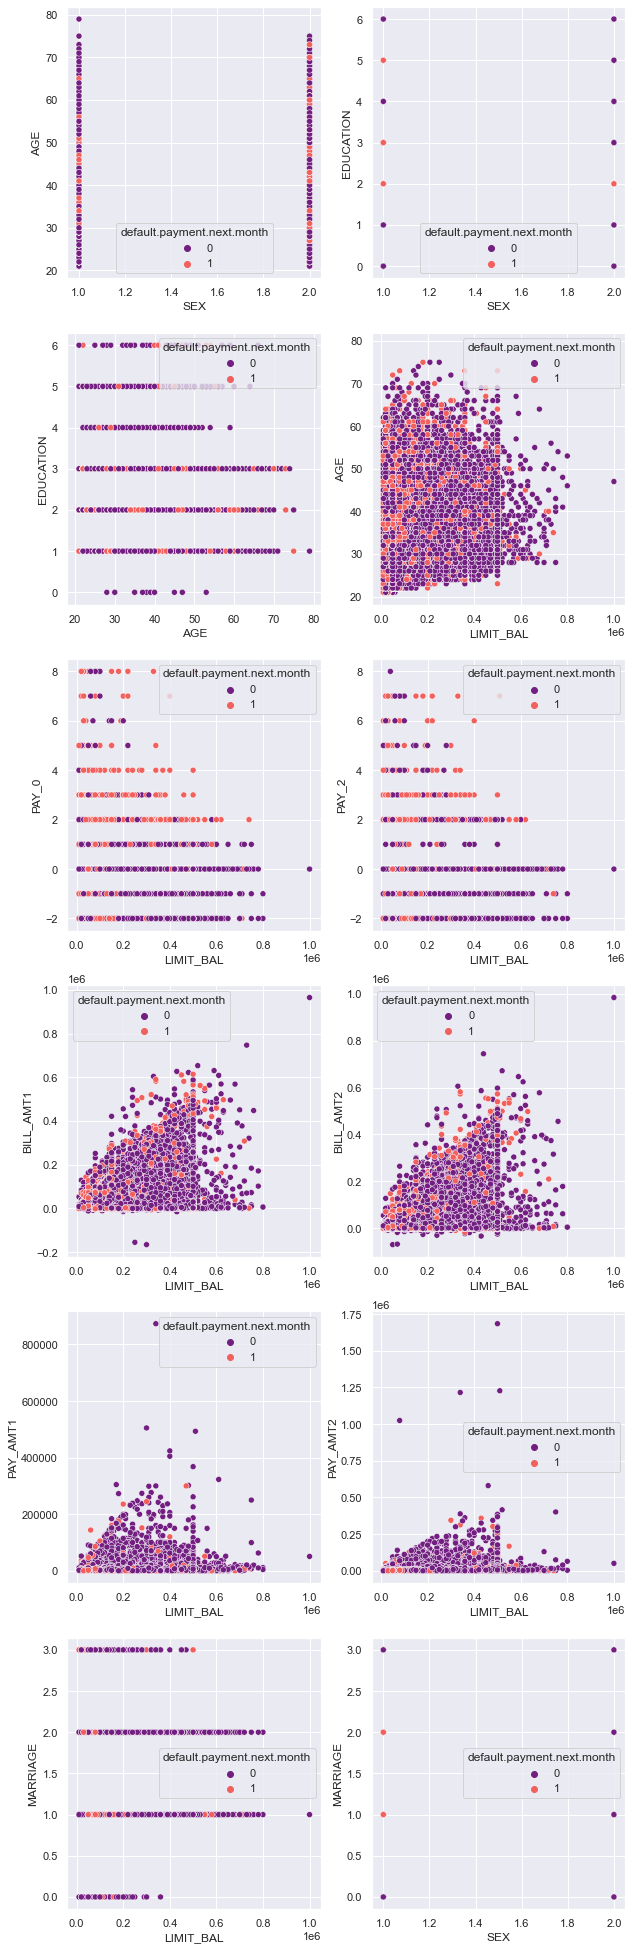

In [24]:
sns.set(rc={'figure.figsize':(10,35)})
f, axes = plt.subplots(6, 2)
sns.set(font_scale=1)
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='SEX', y='AGE', palette = 'magma', ax = axes[0,0])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='SEX', y='EDUCATION', palette = 'magma', ax = axes[0,1])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='AGE', y='EDUCATION', palette = 'magma', ax = axes[1,0])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='LIMIT_BAL', y='AGE', palette = 'magma', ax = axes[1,1])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='LIMIT_BAL', y='PAY_0', palette = 'magma', ax = axes[2,0])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='LIMIT_BAL', y='PAY_2', palette = 'magma', ax = axes[2,1])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='LIMIT_BAL', y='BILL_AMT1', palette = 'magma', ax = axes[3,0])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='LIMIT_BAL', y='BILL_AMT2', palette = 'magma', ax = axes[3,1])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='LIMIT_BAL', y='PAY_AMT1', palette = 'magma', ax = axes[4,0])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='LIMIT_BAL', y='PAY_AMT2', palette = 'magma', ax = axes[4,1])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='LIMIT_BAL', y='MARRIAGE', palette = 'magma', ax = axes[5,0])
sns.scatterplot(data=df, hue = df['default.payment.next.month'], x='SEX', y='MARRIAGE', palette = 'magma', ax = axes[5,1])

Dos gráficos mostrados, podemos observar que:
- Em geral, os clientes de maior idade são homens.
- Os homens costumam ser mais inadimplentes que as mulheres neste dataset.
- Os clientes de maior idade possuem pós-graduação.
- Em geral, um cliente com um limite alto não será inadimplente.
- Os clientes com os maiores limites têm uma idade entre 40 e 60 anos.
- Os clientes que apresentam atrasos na primeira parcela serão inadimplentes.
- Em geral, a maior parte dos clientes que pagaram a primeira parcela na data certa não serão inadimplentes. A mesma tendência pode ser observada em relação à feature 'PAY_2'.
- São poucos os clientes com faturas maiores aos limites de crédito. Além disso, existem alguns clientes com faturas negativas.
- Aparentemente, as pessoas solteiras e casadas possuem um maior crédito disponível.

In [25]:
df[df.BILL_AMT1 < 0]

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
26       60000.0    1          1         2   27      1     -2     -1     -1   
68      130000.0    2          3         2   29      1     -2     -2     -1   
92      100000.0    2          1         2   27     -2     -2     -2     -2   
101     380000.0    2          1         2   30     -2     -2     -1      0   
109     360000.0    1          2         1   35      1     -2     -2     -2   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29811    10000.0    1          2         1   37      1     -2     -1      3   
29817   270000.0    1          2         2   36      1     -1     -1     -2   
29887   150000.0    1          2         1   35      1     -2     -2     -2   
29927    50000.0    1          2         2   30      1     -1      2     -1   
29963    80000.0    1          3         1   41      1     -1      0      0   

       PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
26        -1     -1     -109.0     -425.0      259.0      -57.0      127.0   
68         2     -1     -190.0    -9850.0    -9850.0    10311.0    10161.0   
92        -2     -2    -2000.0     5555.0        0.0        0.0        0.0   
101        0      0      -81.0     -303.0    32475.0    32891.0    33564.0   
109       -2     -2     -103.0     -103.0     -103.0     -103.0     -103.0   
...      ...    ...        ...        ...        ...        ...        ...   
29811      2      0     -265.0     -265.0     5235.0     5007.0     4779.0   
29817     -1      0      -16.0     3326.0      -54.0      -54.0    19315.0   
29887     -2     -2      -18.0      -18.0      -18.0      -18.0      -18.0   
29927     -1     -2     -264.0      264.0      264.0     7300.0        0.0   
29963      0     -1    -1645.0    78379.0    76304.0    52774.0    11855.0   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
26        -189.0       0.0    1000.0       0.0     500.0       0.0    1000.0   
68        7319.0       0.0       0.0   20161.0       0.0    7319.0   13899.0   
92           0.0    7555.0       0.0       0.0       0.0       0.0       0.0   
101      34056.0     223.0   33178.0    1171.0    1197.0    1250.0    5000.0   
109       -103.0       0.0       0.0       0.0       0.0       0.0       0.0   
...          ...       ...       ...       ...       ...       ...       ...   
29811     7680.0       0.0    5500.0       0.0       0.0    3000.0    2000.0   
29817     8388.0    3342.0       0.0       0.0   19369.0     996.0       3.0   
29887      -18.0       0.0       0.0       0.0       0.0       0.0       0.0   
29927        0.0     528.0       0.0    7300.0       0.0       0.0       0.0   
29963    48944.0   85900.0    3409.0    1178.0    1926.0   52964.0    1804.0   

       default.payment.next.month  
26                              1  
68                              0  
92                              0  
101                             0  
109                             0  
...                           ...  
29811                           1  
29817                           0  
29887                           0  
29927                           0  
29963                           1  

[590 rows x 24 columns]

Usualmente, uma fatura negativa significa que a empresa está devendo dinheiro ao cliente. Portanto, não vamos considerar este fato como um erro.

Vamos agora usar boxplots para observar os possíveis outliers:

<AxesSubplot:xlabel='default.payment.next.month', ylabel='PAY_AMT2'>

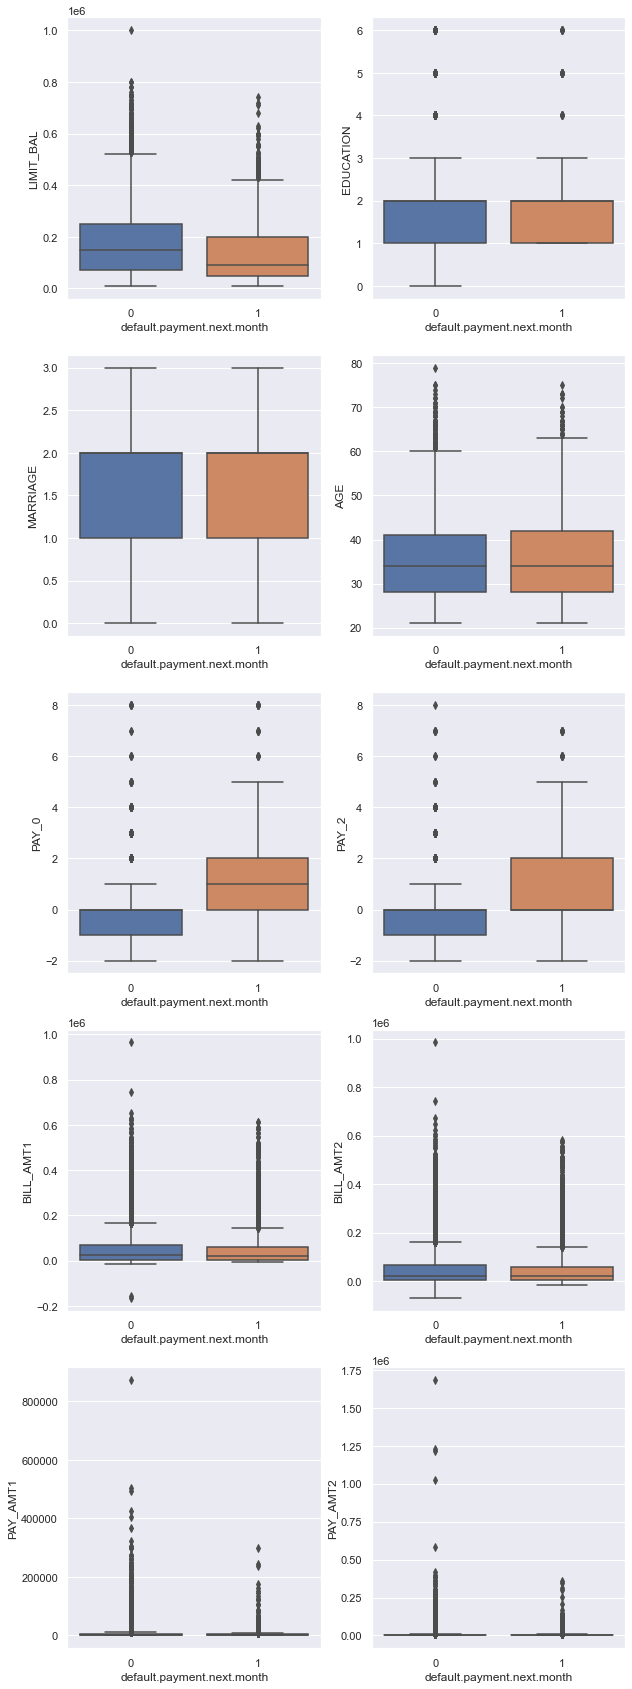

In [26]:
sns.set(rc={'figure.figsize':(10,30)})
sns.set(font_scale = 1)
f, axes = plt.subplots(5, 2)
sns.boxplot(data=df, x='default.payment.next.month', y='LIMIT_BAL', ax = axes[0,0])
sns.boxplot(data=df, x='default.payment.next.month', y='EDUCATION', ax = axes[0,1])
sns.boxplot(data=df, x='default.payment.next.month', y='MARRIAGE', ax = axes[1,0])
sns.boxplot(data=df, x='default.payment.next.month', y='AGE', ax = axes[1,1])
sns.boxplot(data=df, x='default.payment.next.month', y='PAY_0', ax = axes[2,0])
sns.boxplot(data=df, x='default.payment.next.month', y='PAY_2', ax = axes[2,1])
sns.boxplot(data=df, x='default.payment.next.month', y='BILL_AMT1', ax = axes[3,0])
sns.boxplot(data=df, x='default.payment.next.month', y='BILL_AMT2', ax = axes[3,1])
sns.boxplot(data=df, x='default.payment.next.month', y='PAY_AMT1', ax = axes[4,0])
sns.boxplot(data=df, x='default.payment.next.month', y='PAY_AMT2', ax = axes[4,1])


Dos boxplots, pode-se afirmar que as variáveis 'PAY_0' e 'PAY_2' apresentam uma separação nos seus valores em relação ao target 'default.payment.next.month'. Assim, podemos esperar que as features 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' e 'PAY_6' serão muito importantes para prever o target.

Podemos observar a existência de outliers nas features 'AGE', 'LIMIT_BAL', 'BILL_AMT1' e 'PAY_AMT1'.

Vamos usar o Inter Quartile Range (IQR) para calcular o número de outliers:

In [27]:
#Selecting the features
cols = df.drop(columns = ['default.payment.next.month']).columns
total = 0
for column in cols:
    q1 = np.quantile(df.dropna(subset = column)[column], 0.25)
    q3 = np.quantile(df.dropna(subset = column)[column], 0.75)
    
    #IQR
    IQR = q3-q1
    #Ranges
    lower_range = q1 - 1.5*IQR
    higher_range = q3 + 1.5*IQR
    
    #Rows that are out of the range
    n = df.dropna(subset = column).shape[0]
    df_outliers = df[(df[column] > higher_range) | (df[column] < lower_range)]
    rows = df_outliers.shape[0]
    outliers = df_outliers.shape[0]*100/n
    print('A feature', column, 'apresenta', rows, 'outliers (', outliers,'%)')
    total = total + rows
print('Número total de outliers:', total)

A feature LIMIT_BAL apresenta 167 outliers ( 0.5573168696812948 %)
A feature SEX apresenta 0 outliers ( 0.0 %)
A feature EDUCATION apresenta 454 outliers ( 1.5151009511096278 %)
A feature MARRIAGE apresenta 0 outliers ( 0.0 %)
A feature AGE apresenta 272 outliers ( 0.9077256799599532 %)
A feature PAY_0 apresenta 3129 outliers ( 10.442182546304021 %)
A feature PAY_2 apresenta 4409 outliers ( 14.713832804939095 %)
A feature PAY_3 apresenta 4208 outliers ( 14.043050225262807 %)
A feature PAY_4 apresenta 3507 outliers ( 11.703654263307191 %)
A feature PAY_5 apresenta 2967 outliers ( 9.90155181044552 %)
A feature PAY_6 apresenta 3078 outliers ( 10.27198398131153 %)
A feature BILL_AMT1 apresenta 2386 outliers ( 7.962623060236943 %)
A feature BILL_AMT2 apresenta 2390 outliers ( 7.975971967295178 %)
A feature BILL_AMT3 apresenta 2469 outliers ( 8.239612881695312 %)
A feature BILL_AMT4 apresenta 2616 outliers ( 8.730185216085433 %)
A feature BILL_AMT5 apresenta 2724 outliers ( 9.090605706657767

Dada a alta quantidade de outliers, não vamos removê-los, pois perderiamos muita informação essencial para o modelo preditivo.

Agora, vamos visualizar a matriz de correlação:

<AxesSubplot:>

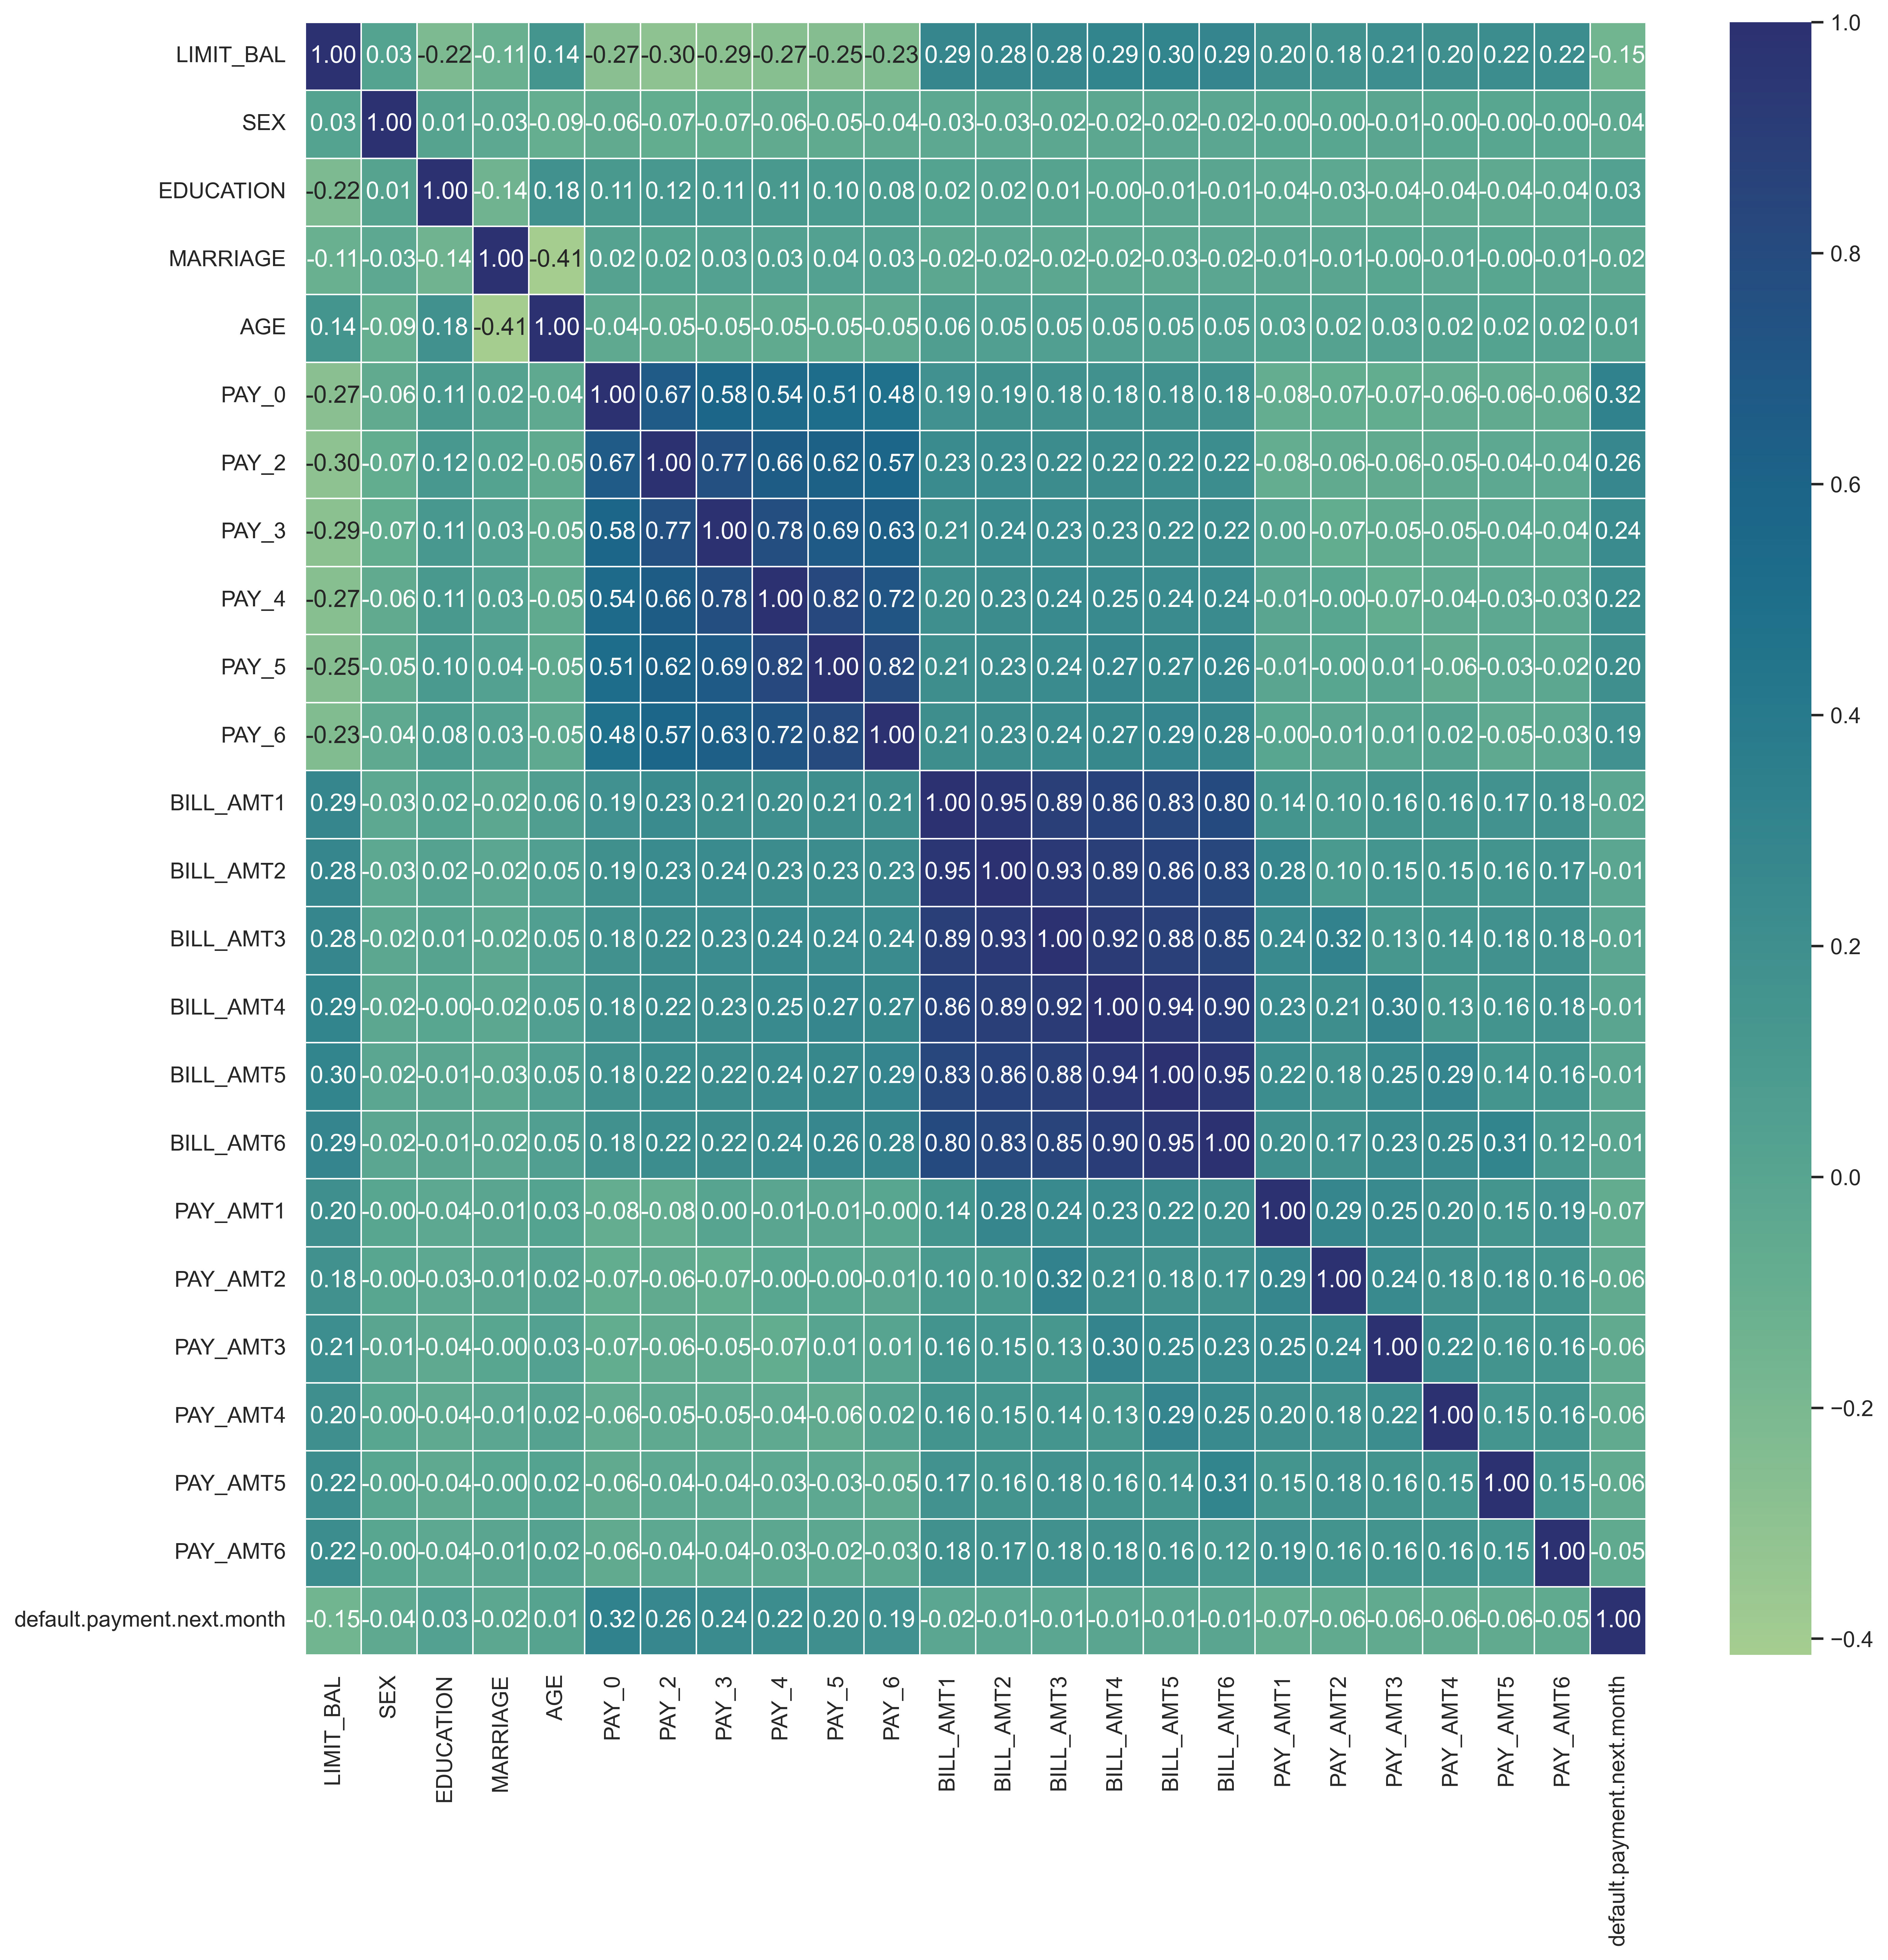

In [28]:
fig = plt.figure(figsize=(15,15), dpi = 480)
sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=1)
sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidth=.5, cmap = 'crest')

- A correlação positiva entre as features 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' e 'PAY_6', e o target 'default.payment.next.month' evidencia que um cliente que apresenta atraso nos pagamentos das faturas possui uma probabilidade considerável de inadimplência.
- A correlação positiva entre as features 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5' e 'BILL_AMT6' indicam que o comportamento mensal de um cliente é relativemente constante.
- A correlação negativa entre as features 'EDUCATION' e 'LIMIT_BAL' indica que as pessoas com uma maior educação podem ter um maior limite de crédito.

## Feature Engineering

Pesquisando sobre a origem do dataset, foram encontrados os seguintes fatos importantes:

- A categoria não conhecida 0 da feature 'EDUCATION' corresponde a outro tipo de educação. Assim, esta categoria será agrupada com as categorias 4, 5 e 6 para criar a cateogoria 4 que indicará outro tipo de educação.
- Similarmente, a categoria não conhecida 0 da feature 'MARRIAGE' será agrupada com a categoria 3 para indicar a nova categoria outro tipo de estado civil.
- Finalmente, as categorias não conhecidas -2 e 0 das features PAY_X indicam que o cliente não teve consumo e que o pagamento mínimo foi feito na data certa, respectivamente. 

Agrupando as categorias da feature 'EDUCATION':

In [29]:
df['EDUCATION'] = df['EDUCATION'].map({0: 4, 1: 1, 2: 2, 3: 3, 4: 4, 5: 4, 6: 4})

Agrupando as categorias da feature 'MARRIAGE':

In [30]:
df['MARRIAGE'] = df['MARRIAGE'].map({0: 3, 1: 1, 2: 2, 3: 3})

Note que estas transformações são feitas no dataset inteiro pois não existe chance de data leakage já que o mapeamento das categorias não depende de outras linhas. Porém, as próximas etapas tais como normalização deverão ser feitas apenas na base de treino para evitar data leakage.

### Encoding de variáveis categóricas

Lembre-se que as features categóricas são 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' e 'PAY_6'. Assim, vamos a usar One Hot Encoding para convertir essas features categóricas para numéricas, as quais serão uteis na construção do modelo preditivo. De novo, não existe data leakage nesta etapa pois o encoding é feito a partir das categorias possíveis de cada feature. 

In [31]:
df = pd.get_dummies(df, columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

In [32]:
df.shape

(29965, 88)

Como era esperado, a quantidade de features aumentou consideravelmente até 88 devido ao One Hot Encoding, o qual cria uma nova feature por cada categoria existente de uma outra feature. Será necessário empregar alguma ferramenta de redução de dimensionalidade para obter as features mais relevantes para o nosso modelo preditivo. Porém, para evitar data leakage, vamos separar o dataset em treino e teste antes. O 30% das linhas serão usadas para testar o modelo. Note que a divisão é estratificada, ou seja, o desbalanceamento do target é mantido na divisão.

In [33]:
#30% do dataset será usado para validar o modelo
y = df['default.payment.next.month']
X = df.drop(columns='default.payment.next.month')
features = X.columns

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)
X_treino = pd.DataFrame(X_treino, columns = features)
X_teste = pd.DataFrame(X_teste, columns = features)

### Balanceamento do target
Com a base de treino isolada da base de teste, vamos balancear a primeira. Para evitar overfitting e que um potencial modelo ignore o valor da classe de menor frequência, é necesário balancear a classe. Para isto, será usado o método SMOTE, que sintetiza novas entradas a partir das existentes. Se o método de oversampling for usado, apenas as linhas com a classe igual a 1 seriam reproduzidas, sem introduzir nova informação ao modelo.

In [34]:
balanceamento_smote = SMOTE(sampling_strategy=0.5)

#Transformando a base de treino processada
X_treino_balanceado, y_treino_balanceado = balanceamento_smote.fit_resample(X_treino,y_treino)
X_treino_balanceado.reset_index(inplace = True, drop = True)
y_treino_balanceado.reset_index(inplace = True, drop = True)

In [35]:
y_treino_balanceado.value_counts(normalize = True)

0    0.666667
1    0.333333
Name: default.payment.next.month, dtype: float64

Agora apenas existem o dobro de linhas nas quais o target é igual a 0 em relação às linhas nas quais o target é igual a 1. 

### Normalização
O seguinte passo será normalizar a nossa base de treino:

In [36]:
normalization = MinMaxScaler()
X_treino_balanceado = normalization.fit_transform(X_treino_balanceado)

### Redução de dimensionalidade
Para evitar os altos custos de processamento e para obter features relevantes para prever o target, vamos usar PCA para reduzir a dimensionalidade da base de treino. A questão principal neste caso é usar a variância explicada acumulada como um indicador para saber a quantidade  de features que são relevantes. Lembre da matriz de correlação que existia uma alta colinearidade entre as features 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5' e 'BILL_AMT6'. Neste caso, PCA também permitirá que informação redundante seja desconsiderada.

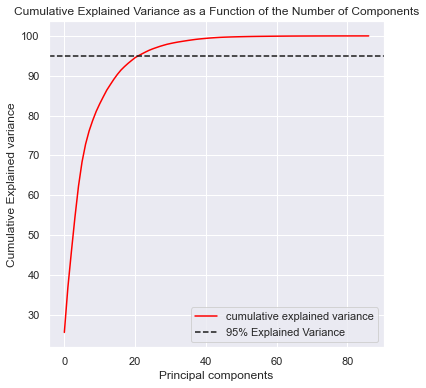

In [37]:
pca = PCA()
pca.fit(X_treino_balanceado)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(6, 6))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

Do gráfico, observa-se que o 95% da variância acumulada é explicada por apenas 20 componentes. Aumentar acima de 20 o número de componentes não contribui significativamente no aumento da variância acumulada. Assim, vamos usar apenas 20 componentes para transformar a nossa base de treino:

In [38]:
pca_2 = PCA(n_components = 20, random_state = 7)
pca_2.fit(X_treino_balanceado)
X_treino_balanceado = pca_2.transform(X_treino_balanceado)
X_treino_balanceado.shape

(24501, 20)

## Algoritmos de classificação
O que acontece se o modelo considera que o target é 0 mas na realidade é 1, ou seja, é um falso negativo (FN)? Isto significaria que o modelo acredita que um cliente inadimplente fez o pagamento certo das faturas. Este fato pode representar uma perda considerável para a empresa, algo que poderia se tornar inaceitável.

Assim, vamos considerar três métricas para avaliar o performance dos algoritmos de classificação: accuracy, ROC-AUC e f1-score. Este último, é simplesmente a média harmônica de precision e recall. Desta forma, podemos levar em conta recall, pois queremos que a quantidade de FN seja menor.

Vamos usar 4 possíveis algoritmos de classificação: decision tree classifier, random forest, logistic regression e k neighbors classifier. Para cada um dos algoritmos candidatos, o tuning de hiperparâmetros é feito antes do treino.

Primeiramente, vamos a definir a função para plotar a curva ROC, a qual também calcula a área sob a curva  AUC:

In [39]:
def plot_roc(prob, y_hat):
    #obtaining fpr, tpr and the corresponding thresholds
    preds = prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_hat, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    #plotting
    plt.figure(figsize=(6,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Decision Tree Classifier
Definindo os hiperparâmetros a serem otimizados:

In [40]:
hyperparameters = { 'criterion': ['gini','entropy'], 'max_depth': np.arange(5, 15), 'max_features': ['auto', 'sqrt', 'log2']}
algorithm = DecisionTreeClassifier(random_state = 7) 
clf_arvore_decisao = GridSearchCV(estimator = algorithm, param_grid = hyperparameters, scoring = 'f1', cv = 5)
clf_arvore_decisao.fit(X_treino_balanceado, y_treino_balanceado)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=7),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='f1')

In [41]:
print('Score F1:', clf_arvore_decisao.best_score_)
print('Os melhores hiperparâmetros são:', clf_arvore_decisao.best_params_)

Score F1: 0.6468782599238898
Os melhores hiperparâmetros são: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto'}


Usando os hiperparâmetoros otimizados para treinar o Decision Tree Classifier:


In [42]:
arvore_decisao = DecisionTreeClassifier(criterion = clf_arvore_decisao.best_params_['criterion'],
                                        max_depth = clf_arvore_decisao.best_params_['max_depth'],
                                        max_features = clf_arvore_decisao.best_params_['max_features'], random_state=7)
arvore_decisao.fit(X_treino_balanceado, y_treino_balanceado)

#Previsões
y_treino_previsao_arvore_decisao = arvore_decisao.predict(X_treino_balanceado)

#Métrica f1
score_f1_treino_arvore_decisao = f1_score(y_treino_balanceado, y_treino_previsao_arvore_decisao)
print('O score f1 de Decision Tree Classifier usando a base de treino é', round(score_f1_treino_arvore_decisao,2))

#Matriz de confusão
matriz_confusao_treino_arvore_decisao  = confusion_matrix(y_treino_balanceado, y_treino_previsao_arvore_decisao)
tn, fp, fn, tp = matriz_confusao_treino_arvore_decisao.ravel()
print('TP =',tp, 'TN =', tn, 'FP =', fp, 'FN =', fn)

O score f1 de Decision Tree Classifier usando a base de treino é 0.72
TP = 5053 TN = 15554 FP = 780 FN = 3114


Plotando a matriz de confusão:

Text(0.5, 1.0, 'Matriz de Confusão da base de treino para Árvore de decisão')

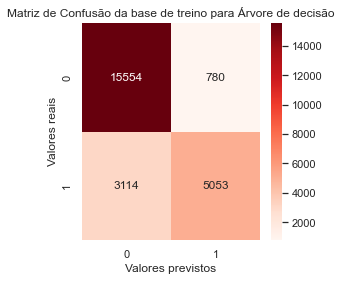

In [43]:
plt.figure(figsize=(4,4))
sns.heatmap(matriz_confusao_treino_arvore_decisao, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])
# labels, title and ticks
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão da base de treino para Árvore de decisão')

Plotando a  curva ROC e mostrando o valor da AUC:

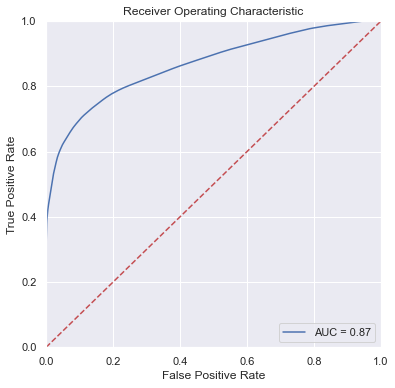

In [44]:
plot_roc(arvore_decisao.predict_proba(X_treino_balanceado), y_treino_balanceado)

#### Random Forest
Definindo os hiperparâmetros a serem otimizados:

In [45]:
parametros = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10,100],
              'criterion': ['gini', 'entropy']}
algoritmo = RandomForestClassifier(random_state = 7, n_jobs = -1) 
clf_random_forest = GridSearchCV(estimator = algoritmo, param_grid = parametros, scoring = 'f1', cv = 5)
clf_random_forest.fit(X_treino_balanceado, y_treino_balanceado)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=7),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 100],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [200, 500]},
             scoring='f1')

In [46]:
print('Score F1:', clf_random_forest.best_score_)
print('Os melhores hiperparâmetros são:', clf_random_forest.best_params_)

Score F1: 0.6634805545168173
Os melhores hiperparâmetros são: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}


Usando os hiperparâmetros otimizados para treinar Random Forest:

In [47]:
random_forest = RandomForestClassifier(n_estimators = clf_random_forest.best_params_['n_estimators'],
                                       max_features = clf_random_forest.best_params_['max_features'], 
                                       max_depth = clf_random_forest.best_params_['max_depth'], 
                                       criterion = clf_random_forest.best_params_['criterion'],
                                       random_state=7, n_jobs=-1)
random_forest.fit(X_treino_balanceado,y_treino_balanceado)

#Previsões
y_treino_previsao_random_forest = random_forest.predict(X_treino_balanceado)

#Métrica f1
score_f1_treino_random_forest = f1_score(y_treino_balanceado, y_treino_previsao_random_forest)
print('O score F1 do algoritmo Random Forest usando a base de treino é', round(score_f1_treino_random_forest,2))

#Matriz de confusão
matriz_confusao_treino_random_forest = confusion_matrix(y_treino_balanceado, y_treino_previsao_random_forest)
tn, fp, fn, tp = matriz_confusao_treino_random_forest.ravel()
print('TP =',tp, 'TN =', tn, 'FP =', fp, 'FN =', fn)

O score F1 do algoritmo Random Forest usando a base de treino é 0.77
TP = 5429 TN = 15766 FP = 568 FN = 2738


Plotando a matriz de confusão:

Text(0.5, 1.0, 'Matriz de Confusão da base de treino para Random Forest')

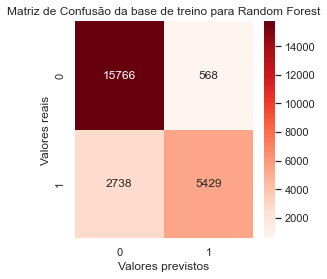

In [48]:
plt.figure(figsize=(4,4))
sns.heatmap(matriz_confusao_treino_random_forest, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])
# labels, title and ticks
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão da base de treino para Random Forest')

Plotando a  curva ROC e mostrando o valor da AUC:

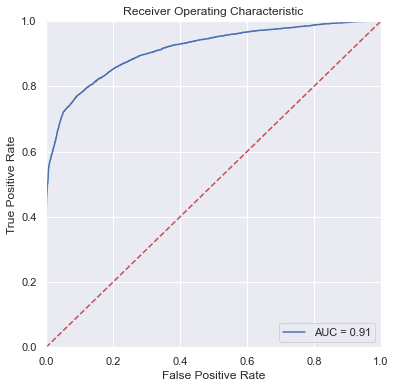

In [49]:
plot_roc(random_forest.predict_proba(X_treino_balanceado), y_treino_balanceado)

#### Logistic Regression
Definindo os hiperparâmetros a serem otimizados:

In [50]:
parametros = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 8),'solver': ['liblinear'], 'tol': np.logspace(-4,4,8)}
algoritmo = LogisticRegression(random_state = 7, n_jobs = -1)
clf_reglog = GridSearchCV(estimator = algoritmo, param_grid = parametros, scoring = 'f1', cv = 5)
clf_reglog.fit(X_treino_balanceado, y_treino_balanceado)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_job

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=7),
             param_grid={'C': array([1.00000000e-04, 1.38949549e-03, 1.93069773e-02, 2.68269580e-01,
       3.72759372e+00, 5.17947468e+01, 7.19685673e+02, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear'],
                         'tol': array([1.00000000e-04, 1.38949549e-03, 1.93069773e-02, 2.68269580e-01,
       3.72759372e+00, 5.17947468e+01, 7.19685673e+02, 1.00000000e+04])},
             scoring='f1')

In [51]:
print('Score F1:',clf_reglog.best_score_)
print('Os melhores hiperparâmetros são:',clf_reglog.best_params_)

Score F1: 0.6721161436307257
Os melhores hiperparâmetros são: {'C': 0.2682695795279725, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}


Usando os hiperparâmetros otimizados para treinar Logistic Regression:

In [52]:
regressao_logistica = LogisticRegression(C = clf_reglog.best_params_['C'], solver = clf_reglog.best_params_['solver'], 
                                         penalty = clf_reglog.best_params_['penalty'], tol = clf_reglog.best_params_['tol'],
                                         random_state = 7, n_jobs = -1)
regressao_logistica.fit(X_treino_balanceado,y_treino_balanceado)

#Previsões
y_treino_previsao_reglog = regressao_logistica.predict(X_treino_balanceado)

#Métrica f1
score_f1_treino_reglog = f1_score(y_treino_balanceado, y_treino_previsao_reglog)
print('O score F1 do algoritmo Regressão Logística usando a base de treino é', round(score_f1_treino_reglog,2))

#Matriz de confusão
matriz_confusao_treino_reglog = confusion_matrix(y_treino_balanceado, y_treino_previsao_reglog)
tn, fp, fn, tp = matriz_confusao_treino_reglog.ravel()
print('TP =',tp, 'TN =', tn, 'FP =', fp, 'FN =', fn)

O score F1 do algoritmo Regressão Logística usando a base de treino é 0.71
TP = 5050 TN = 15389 FP = 945 FN = 3117


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Plotando a matriz de confusão:

Text(0.5, 1.0, 'Matriz de Confusão da base de treino para Regressão Logística')

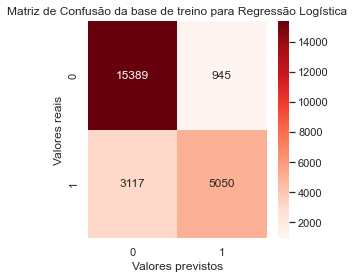

In [53]:
plt.figure(figsize=(4,4))
sns.heatmap(matriz_confusao_treino_reglog, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])
# labels, title and ticks
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão da base de treino para Regressão Logística')

Plotando a  curva ROC e mostrando o valor da AUC:

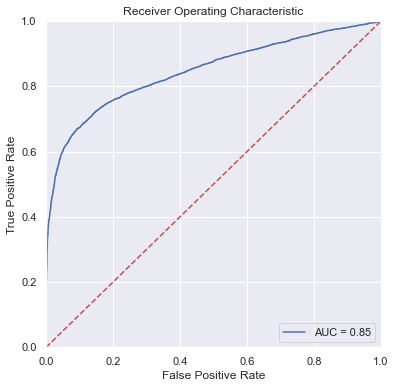

In [54]:
plot_roc(regressao_logistica.predict_proba(X_treino_balanceado), y_treino_balanceado)

#### k Neighbors Classifier
Definindo os hiperparâmetros a serem otimizados:

In [55]:
parametros = {'n_neighbors': list(range(1, 11))}
algoritmo = KNeighborsClassifier(n_jobs = -1)
clf_knc = GridSearchCV(estimator = algoritmo, param_grid = parametros, scoring = 'f1', cv = 5)
clf_knc.fit(X_treino_balanceado, y_treino_balanceado)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='f1')

In [56]:
print('Score F1:',clf_knc.best_score_)
print('Os melhores hiperparâmetros são:',clf_knc.best_params_)

Score F1: 0.6581128823651994
Os melhores hiperparâmetros são: {'n_neighbors': 9}


Usando os hiperparâmetros otimizados para treinar o k Neighbors Classifier:

In [57]:
knnc = KNeighborsClassifier(n_neighbors = clf_knc.best_params_['n_neighbors'], n_jobs = -1)
knnc.fit(X_treino_balanceado,y_treino_balanceado)

#Previsões
y_treino_previsao_knc = knnc.predict(X_treino_balanceado)

#Métrica f1
score_f1_treino_knc = f1_score(y_treino_balanceado, y_treino_previsao_knc)
print('O score f1 do algoritmo k Neighbors Classifier usando a base de treino é', round(score_f1_treino_knc,2))

#Matriz de confusão
matriz_confusao_treino_knc = confusion_matrix(y_treino_balanceado, y_treino_previsao_knc)
tn, fp, fn, tp = matriz_confusao_treino_knc.ravel()
print('TP =',tp, 'TN =', tn, 'FP =', fp, 'FN =', fn)

O score f1 do algoritmo k Neighbors Classifier usando a base de treino é 0.74
TP = 5332 TN = 15381 FP = 953 FN = 2835


Plotando a matriz de confusão:

Text(0.5, 1.0, 'Matriz  de Confusão da base de treino para k Neighors Classifier')

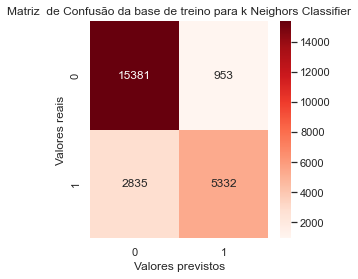

In [58]:
plt.figure(figsize=(4,4))
sns.heatmap(matriz_confusao_treino_knc, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])
# labels, title and ticks
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.title('Matriz  de Confusão da base de treino para k Neighors Classifier')

Plotando a  curva ROC e mostrando o valor da AUC:

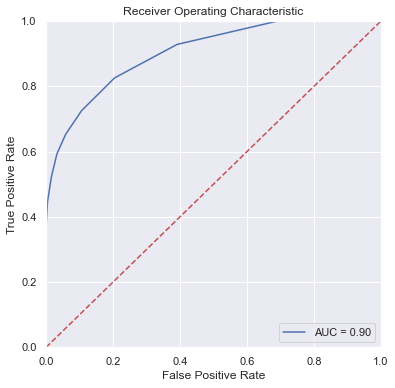

In [59]:
plot_roc(knnc.predict_proba(X_treino_balanceado), y_treino_balanceado)

## Avaliando os algoritmos de classificação na base de teste
Antes de avaliar o performance dos algoritmos de classificação na base de teste, é necessário processar esta com as etapas de normalização e redução de dimensionalidade. Lembre-se que estas etapas foram criadas com a base de treino para evitar data leakage. A seguinte função preparará a base de teste para a avaliação dos algoritmos: 

In [60]:
def preprocessamento_teste(X_teste, normalization, pca):
   
    #normalizando
    X_teste = normalization.transform(X_teste)
    
    #aplicando pca
    X_teste = pca.transform(X_teste)
    
    return X_teste

In [61]:
X_teste = preprocessamento_teste(X_teste, normalization, pca_2)

In [62]:
X_teste.shape

(8990, 20)

A base de teste já está pronta para avaliar o rendimento dos algoritmos de classificação:

#### Decision Tree Classifier

O score f1 de Decision Tree Classifier usando a base de teste é 0.44
TP = 683 TN = 6546 FP = 455 FN = 1306


Text(0.5, 1.0, 'Matriz de Confusão da base de teste para Árvore de decisão')

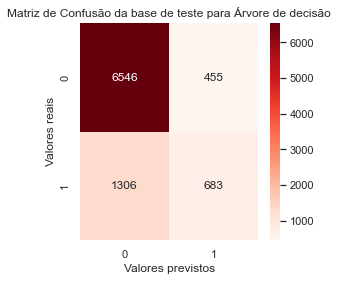

In [63]:
#Usando o algoritmo de árvore de decisão otimizado
y_teste_previsao_arvore_decisao = arvore_decisao.predict(X_teste)

#Métrica f1
score_f1_teste_arvore_decisao = f1_score(y_teste, y_teste_previsao_arvore_decisao)
print('O score f1 de Decision Tree Classifier usando a base de teste é', round(score_f1_teste_arvore_decisao,2))

#Matriz de confusão
matriz_confusao_teste_arvore_decisao  = confusion_matrix(y_teste, y_teste_previsao_arvore_decisao)
tn, fp, fn, tp = matriz_confusao_teste_arvore_decisao.ravel()
print('TP =',tp, 'TN =', tn, 'FP =', fp, 'FN =', fn)

plt.figure(figsize=(4,4))
sns.heatmap(matriz_confusao_teste_arvore_decisao, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])
# labels, title and ticks
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão da base de teste para Árvore de decisão')

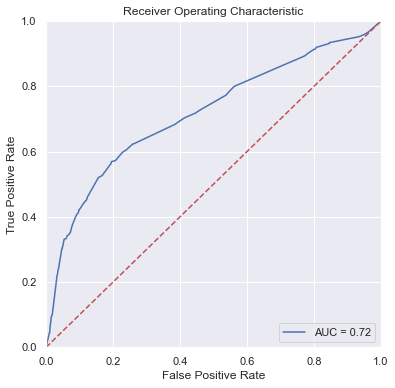

In [64]:
plot_roc(arvore_decisao.predict_proba(X_teste), y_teste)

#### Random Forest

O score f1 de Random Forest usando a base de teste é 0.47
TP = 736 TN = 6621 FP = 380 FN = 1253


Text(0.5, 1.0, 'Matriz de Confusão da base de teste para Random Forest')

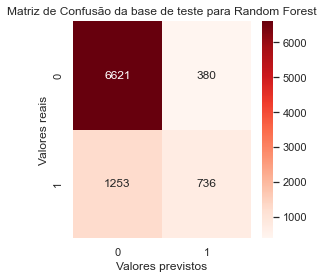

In [65]:
#Usando o algoritmo de random forest otimizado
y_teste_previsao_random_forest = random_forest.predict(X_teste)

#Métrica f1
score_f1_teste_random_forest = f1_score(y_teste, y_teste_previsao_random_forest)
print('O score f1 de Random Forest usando a base de teste é', round(score_f1_teste_random_forest,2))

#Matriz de confusão
matriz_confusao_teste_random_forest  = confusion_matrix(y_teste, y_teste_previsao_random_forest)
tn, fp, fn, tp = matriz_confusao_teste_random_forest.ravel()
print('TP =',tp, 'TN =', tn, 'FP =', fp, 'FN =', fn)

plt.figure(figsize=(4,4))
sns.heatmap(matriz_confusao_teste_random_forest, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])
# labels, title and ticks
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão da base de teste para Random Forest')


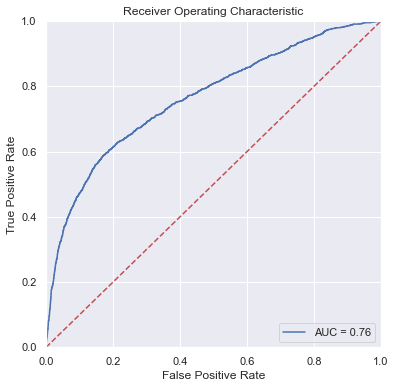

In [66]:
plot_roc(random_forest.predict_proba(X_teste), y_teste)

#### Logistic Regression

O score f1 de Regressão Logística usando a base de teste é 0.48
TP = 761 TN = 6591 FP = 410 FN = 1228


Text(0.5, 1.0, 'Matriz de Confusão da base de teste para Regressão Logística')

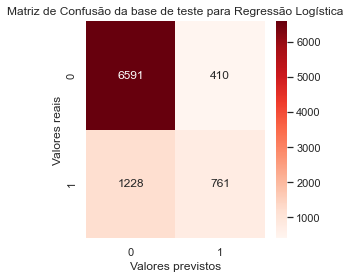

In [67]:
#Usando o algoritmo de regressão logística otimizado
y_teste_previsao_reglog = regressao_logistica.predict(X_teste)

#Métrica f1
score_f1_teste_reglog = f1_score(y_teste, y_teste_previsao_reglog)
print('O score f1 de Regressão Logística usando a base de teste é', round(score_f1_teste_reglog,2))

#Matriz de confusão
matriz_confusao_teste_reglog  = confusion_matrix(y_teste, y_teste_previsao_reglog)
tn, fp, fn, tp = matriz_confusao_teste_reglog.ravel()
print('TP =',tp, 'TN =', tn, 'FP =', fp, 'FN =', fn)

plt.figure(figsize=(4,4))
sns.heatmap(matriz_confusao_teste_reglog, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])
# labels, title and ticks
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão da base de teste para Regressão Logística')

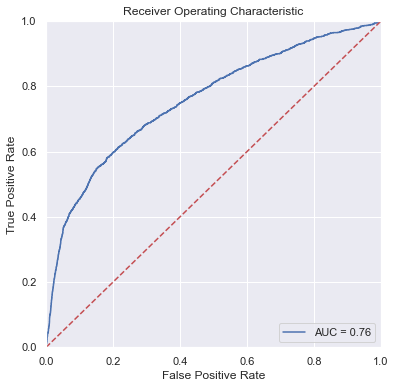

In [68]:
plot_roc(regressao_logistica.predict_proba(X_teste), y_teste)

#### k Neighbors Classifier


O score f1 de AdaBoost usando a base de teste é 0.46
TP = 759 TN = 6479 FP = 522 FN = 1230


Text(0.5, 1.0, 'Matriz de Confusão da base de teste para k Neighbors Classifier')

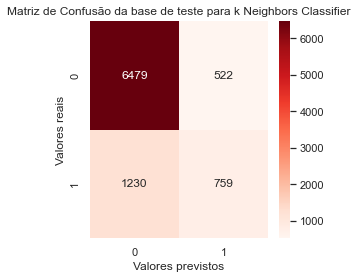

In [69]:
#Usando o algoritmo de k Neighbors Classifier otimizado
y_teste_previsao_knc = knnc.predict(X_teste)

#Métrica f1
score_f1_teste_knc = f1_score(y_teste, y_teste_previsao_knc)
print('O score f1 de AdaBoost usando a base de teste é', round(score_f1_teste_knc,2))

#Matriz de confusão
matriz_confusao_teste_knc  = confusion_matrix(y_teste, y_teste_previsao_knc)
tn, fp, fn, tp = matriz_confusao_teste_knc.ravel()
print('TP =',tp, 'TN =', tn, 'FP =', fp, 'FN =', fn)

plt.figure(figsize=(4,4))
sns.heatmap(matriz_confusao_teste_knc, annot = True, fmt=".0f",cmap='Reds', xticklabels = [0,1], yticklabels = [0,1])
# labels, title and ticks
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão da base de teste para k Neighbors Classifier')

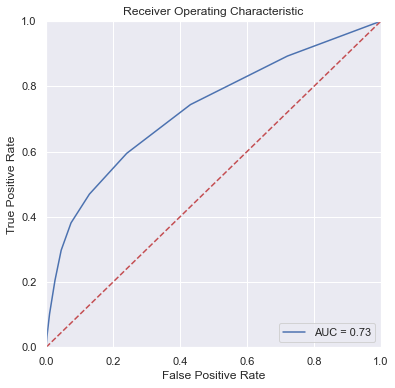

In [70]:
plot_roc(knnc.predict_proba(X_teste), y_teste)

## Resultados
A seguinte tabela mostra as métricas obtidas para as bases de treino e teste usando os 4 algoritmos candidatos. Lembre-se que a métrica accuracy indica a proporção de previsões corretas e é dada por (TN+TP)/(TN+FN+TP+FP):

In [71]:
results = pd.DataFrame(np.array([[0.87, round((5963+17697)/(5963+17697+971+3371),2), round(score_f1_treino_arvore_decisao,2), 0.74, round((513+4364)/(513+4364+303+813),2), round(score_f1_teste_arvore_decisao,2)],
[0.91, round((6123+17957)/(6123+17957+711+3211),2), round(score_f1_treino_random_forest,2), 0.77, round((500+4404)/(500+4404+263+826),2), round(score_f1_teste_random_forest,2)],
[0.85, round((5791+17524)/(5791+17524+1144+3543),2), round(score_f1_treino_reglog,2), 0.76, round((519+4382)/(519+4382+285+807),2), round(score_f1_teste_reglog,2)],
[0.90, round((6095+17571)/(6095+17571+1097+3239),2), round(score_f1_treino_knc,2), 0.73, round((4344+511)/(4344+511+815+323),2), round(score_f1_teste_knc,2)]]),
                        index = ['Decision Tree Classifier', 'Random Forest', 'Logistic Reggression', 'k Neighbors Classifier'],
                        columns = ['AUC-Treino', 'Accuracy-Treino', 'Score F1-Treino', 'AUC-Teste', 'Accuracy-Teste', 'Score F1-Teste'])
results

AUC-Treino  Accuracy-Treino  Score F1-Treino  \
Decision Tree Classifier        0.87             0.84             0.72   
Random Forest                   0.91             0.86             0.77   
Logistic Reggression            0.85             0.83             0.71   
k Neighbors Classifier          0.90             0.85             0.74   

                          AUC-Teste  Accuracy-Teste  Score F1-Teste  
Decision Tree Classifier       0.74            0.81            0.44  
Random Forest                  0.77            0.82            0.47  
Logistic Reggression           0.76            0.82            0.48  
k Neighbors Classifier         0.73            0.81            0.46

Da tabela, pode-se concluir que o melhor algoritmo de classificação para nosso modelo preditivo é Random Forest.

## Conclusão
Um modelo preditivo foi proposto com o intuito de prever se um cliente pode se tornar inadimplente levando em conta informações demográficas e o comportamento creditício. No geral, os quatro algoritmos candidatos apresentam boas métricas tanto na base de treino como de teste. Porém, Random Forest foi escolhido como o melhor algoritmo de classificação para este modelo. 

O modelo proposto consiste da utilização de OHE, redução de dimensionalidade com PCA, balanceamento, normalização e feature engineering para preprocessar a base antes da aplicação dos algoritmos. Em cada etapa, data leakage foi evitado com o objetivo de evitar resultados superestimados.